In [1]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.feather as feather
from matplotlib import rcParams as rcParams
from atlasify import atlasify
from matplotlib import gridspec
import matplotlib as mlp
np.seterr(divide='ignore', invalid='ignore')
from sklearn import metrics
import json
import seaborn as sns

Loads data from arrow files, adds information like signal region, process, and whether the event is signal or not.

In [8]:
#dictionary to convert signal region numbers into words
srconvert={0:"SFinZ",1:"SFnoZ",2:"DF",-1:"CR"}
crconvert={0:"ZZ",1:"ttZ"}
srs=["SFinZ","SFnoZ","DF"]
crs=["ttZ","ZZ"]
#variables used for training
variables = ['leptonic_HT', 'MET', 'Zlep1_dphi',
       'Wlep1_pt', 'total_HT', 'Zlep2_dphi', 'Zlep2_eta', 'Njet', 'Wlep2_eta',
       'Zlep2_pt', 'METSig', 'other_mass', 'Wlep1_dphi', 'Zlep1_pt',
       'mass_4l', 'pt_4l', 'Zlep1_eta', 'HT', 'Wlep1_eta',
       'Wlep2_dphi', 'Zcand_mass', 'Wlep2_pt','MET_dPhi']
#alternate variables proposed by michigan
#variables = ["leptonic_HT","HT","MET","METSig","pt_4l","Zlep1_dphi","Zlep1_eta","Zlep1_pt","Zlep2_dphi","Zlep2_eta",
#             "Zlep2_pt","Wlep1_dphi","Wlep1_eta","Wlep1_pt","Wlep2_dphi","Wlep2_eta","Wlep2_pt","Njet","other_mass",
#             "Zcand_mass","mass_4l","MET_dPhi","chisq","Wleps_deta","Wleps_dphi"]
#variables not used at all
excessVariables=["v_j_btag60",
                   "v_j_btag70", "v_j_btag77", 
                   "v_j_btag85", "v_j_btagCont",
                   "pt_1","pt_2","pt_3","pt_4",
                   "eta_1","eta_2","eta_3","eta_4",
                   "phi_1","phi_2","phi_3","phi_4",
                   "lep1_pid", "lep2_pid", 
                   "lep3_pid", "lep4_pid", "Nlep",
                   "Zlep1_pid", "Zlep2_pid", 
                   "Wlep1_pid", "Wlep2_pid",
                  "jet_pt_1", "jet_pt_2", "jet_pt_3", "jet_pt_4",
                   "jet_eta_1", "jet_eta_2", "jet_eta_3", "jet_eta_4",
                   "jet_phi_1", "jet_phi_2", "jet_phi_3", "jet_phi_4",
                   "jet_m_1", "jet_m_2", "jet_m_3", "jet_m_4",
                   "jet_btagCont_1", "jet_btagCont_2", "jet_btagCont_3", "jet_btagCont_4"]
#11 main processes
processes=["Signal", "ZZ", "Zjets", "Zgamma", "ttbar", "WZ", "tZ", "ttZ", "tWZ", "VBS", "VH", "Others"]
#signal subprocesses
sigprocesses=["Signal_WZZ_3l1v2j","Signal_ZZZ_4l2j", "Signal_WZZ_3l3v","Signal_ZZZ_4l2v","Signal_WWZ_2l4v","Signal_WZZ_4l2j","Signal_ZZZ_6l0v",
              "Signal_WWZ_3l1v2j","Signal_WZZ_5l1v","Signal_WWZ_4l2v","Signal_ZZZ_2l4v"]
#dictionaries to fill with events from processes and subprocessses
processDict={}
sigprocessDict={}
#path to files:
arrowLocation="/data/jiling/WVZ/v2.3-2023_01_16_arrow/"
for process in processes:
    print("Loading process: "+process)
    if process=="Signal": #if loading signal, instead load subprocesses
        for sigprocess in sigprocesses:
            #loads file from location of arrow files
            sigprocessDict[sigprocess]=pd.DataFrame(feather.read_feather(arrowLocation+sigprocess+".arrow"))
            print("\tLoaded data...")
            #adds collumn to dataframe to distinguish signal subprocesses
            sigprocessDict[sigprocess]["sigprocess"] = [sigprocess for x in range(len(sigprocessDict[sigprocess]))]
            #removes excess variables
            sigprocessDict[sigprocess]=sigprocessDict[sigprocess].drop(excessVariables,axis=1)
            sigprocessDict[sigprocess]["SR"] = [srconvert[x] for x in sigprocessDict[sigprocess].SR]
        processDict[process]=pd.concat(sigprocessDict.values())
        #creates is_signal variable to train with and process variable to distinguish processes
        processDict[process]["is_signal"] = [1 for x in range(len(processDict[process]))]
    else:
        processDict[process]=pd.DataFrame(feather.read_feather(arrowLocation+process+".arrow"))
        print("\tLoaded data...")
        processDict[process]["is_signal"] = [0 for x in range(len(processDict[process]))]
        processDict[process]=processDict[process].drop(excessVariables,axis=1)#removes excess variables
        processDict[process]["sigprocess"] = ["Background" for x in range(len(processDict[process]))]
        processDict[process]["SR"] = [srconvert[x] for x in processDict[process].SR]
    processDict[process]["process"] = [process for x in range(len(processDict[process]))]
#adds all processes together into one dataset
refined_data=pd.concat(processDict.values(),ignore_index=True)
all_data=refined_data.copy()
all_data.loc[all_data.sr_SF_inZ==1,"CRSR"]=0
all_data.loc[all_data.sr_SF_noZ==1,"CRSR"]=1
all_data.loc[all_data.sr_DF==1,"CRSR"]=2
all_data.loc[all_data.cr_ttZ==1,"CRSR"]=3
all_data.loc[all_data.cr_ZZ==1,"CRSR"]=4

CRset=refined_data[refined_data.cr_ttZ+refined_data.cr_ZZ==1]
CRset["CR"]= [crconvert[x] for x in CRset.cr_ttZ]
CRset.loc[CRset.sr_SF_inZ==1,"SR"]=0
CRset.loc[CRset.sr_SF_noZ==1,"SR"]=1
CRset.loc[CRset.sr_DF==1,"SR"]=2
refined_data=refined_data[refined_data.SR!="CR"]

Loading process: Signal
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
	Loaded data...
Loading process: ZZ
	Loaded data...
Loading process: Zjets
	Loaded data...
Loading process: Zgamma
	Loaded data...
Loading process: ttbar
	Loaded data...
Loading process: WZ
	Loaded data...
Loading process: tZ
	Loaded data...
Loading process: ttZ
	Loaded data...
Loading process: tWZ
	Loaded data...
Loading process: VBS
	Loaded data...
Loading process: VH
	Loaded data...
Loading process: Others
	Loaded data...


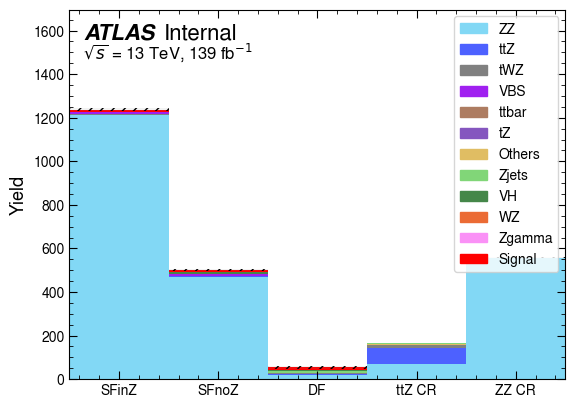

In [17]:
processes=["ZZ","ttZ","tWZ","VBS","ttbar","tZ","Others","Zjets","VH","WZ","Zgamma","Signal"]
crfull={"ttZ":"4ℓ-ttZ","ZZ":"4ℓ-ZZ"}
colors={"ZZ":"#82D8F5",
        "ttZ":"#4D61FF",
        "tWZ":"#808080",
        "VBS":"#A020F0",
        "ttbar":"#AD7C61",
        "tZ":"#8556BF",
        "Others":"#E0BD63",
        "Zjets":"#81D678",
        "VH":"#458749",
        "WZ":"#EB6B34",
        "Zgamma":"#FA91F6",
        "Signal":"#FF0000"}
variable="CRSR"
xmin=0
xmax=5
bins=np.linspace(xmin,xmax,6)
tostack=[]
tostackbins=[]
for process in processes:
    tostackbins.append(bins[:-1])
    tostack.append(np.histogram(np.clip(all_data[variable][all_data.process==process], bins[0], bins[-1]),bins=bins,weights=all_data[all_data.process==process].wgt)[0])
combinedhists=np.stack(tostack)
combinedbins=np.stack(tostackbins)
barwidth=(bins[1]-bins[0])
error=np.sqrt(np.histogram(np.clip(all_data[variable], bins[0], bins[-1]),bins=bins,weights=np.square(all_data.wgt))[0])
plt.hist(np.transpose(combinedbins),weights=np.transpose(combinedhists),stacked=True,bins=bins,color=list(colors.values()))
plt.bar((bins + barwidth/2)[:-1], 2*error, bottom=np.sum(np.transpose(combinedhists),axis=1)-error, width=barwidth,hatch='///',color=(0.5, 0.5, 0.5,0.1))
atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n',outside=False)
plt.xlim(xmin,xmax)
plt.ylabel("Yield",size=13)
plt.xticks([0.5,1.5,2.5,3.5,4.5],["SFinZ","SFnoZ","DF","ttZ CR","ZZ CR"])
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in list(colors.keys())]
plt.legend(handles, list(colors.keys()),loc='upper right')
plt.show()

In [4]:
data=pd.DataFrame(feather.read_feather(arrowLocation+"Data.arrow"))
data=data[data.cr_ttZ+data.cr_ZZ==1]
data["CR"]= [crconvert[x] for x in data.cr_ttZ]
data.loc[data.sr_SF_inZ==1,"SR"]=0
data.loc[data.sr_SF_noZ==1,"SR"]=1
data.loc[data.sr_DF==1,"SR"]=2

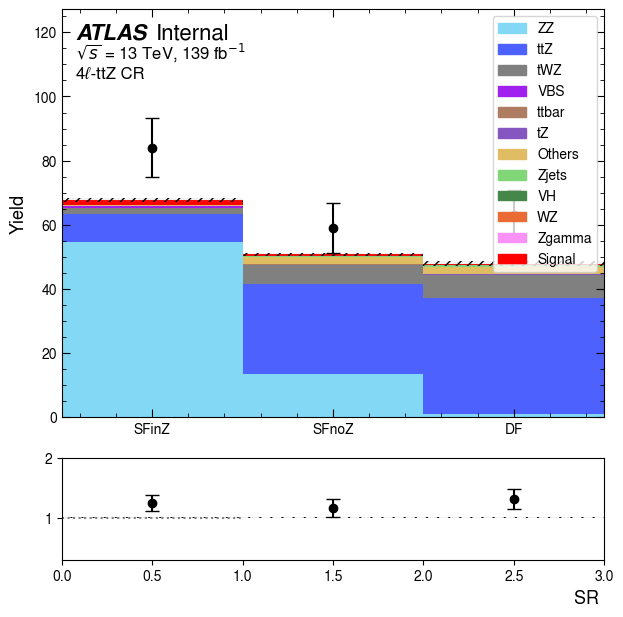

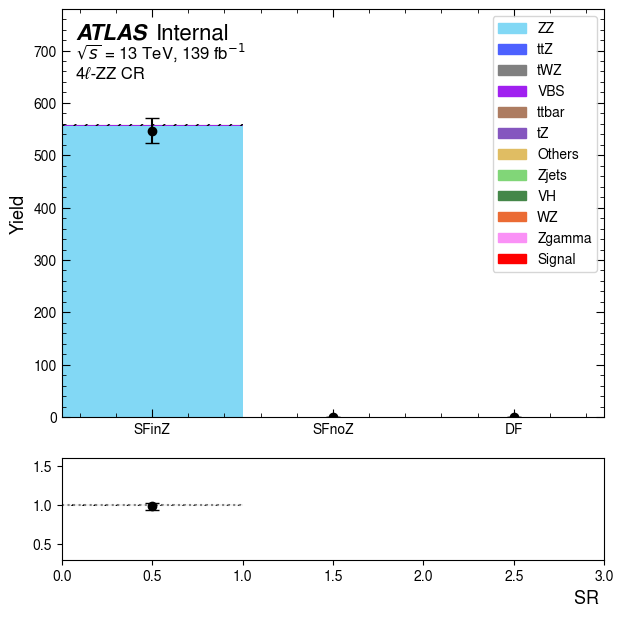

In [18]:
processes=["ZZ","ttZ","tWZ","VBS","ttbar","tZ","Others","Zjets","VH","WZ","Zgamma","Signal"]
crfull={"ttZ":"4ℓ-ttZ","ZZ":"4ℓ-ZZ"}
colors={"ZZ":"#82D8F5",
        "ttZ":"#4D61FF",
        "tWZ":"#808080",
        "VBS":"#A020F0",
        "ttbar":"#AD7C61",
        "tZ":"#8556BF",
        "Others":"#E0BD63",
        "Zjets":"#81D678",
        "VH":"#458749",
        "WZ":"#EB6B34",
        "Zgamma":"#FA91F6",
        "Signal":"#FF0000"}
xmins={'leptonic_HT':0, 
       'MET':0, 
       'Zlep1_dphi':-2,
       'Wlep1_pt':0, 
       'total_HT':0, 
       'Zlep2_dphi':-5, 
       'Zlep2_eta':-4, 
       'Njet':0, 
       'Wlep2_eta':-4,
       'Zlep2_pt':0, 
       'METSig':0, 
       'other_mass':0, 
       'Wlep1_dphi':-5, 
       'Zlep1_pt':0,
       'mass_4l':0, 
       'pt_4l':0, 
       'Zlep1_eta':-4, 
       'HT':0, 
       'Wlep1_eta':-5,
       'Wlep2_dphi':-5, 
       'Zcand_mass':70, 
       'Wlep2_pt':0,
       'MET_dPhi':-5,
       'SR':0}
xmaxs={'leptonic_HT':700, 
       'MET':250, 
       'Zlep1_dphi':2,
       'Wlep1_pt':250, 
       'total_HT':1200, 
       'Zlep2_dphi':5, 
       'Zlep2_eta':4, 
       'Njet':7, 
       'Wlep2_eta':4,
       'Zlep2_pt':100, 
       'METSig':14, 
       'other_mass':250, 
       'Wlep1_dphi':5, 
       'Zlep1_pt':250,
       'mass_4l':800, 
       'pt_4l':300, 
       'Zlep1_eta':4, 
       'HT':500, 
       'Wlep1_eta':4,
       'Wlep2_dphi':5, 
       'Zcand_mass':110, 
       'Wlep2_pt':120,
       'MET_dPhi':5,
       'SR':3}
xs={'leptonic_HT':"(GeV)", 
       'MET':"(GeV)", 
       'Zlep1_dphi':"",
       'Wlep1_pt':"(GeV)", 
       'total_HT':"(GeV)", 
       'Zlep2_dphi':"", 
       'Zlep2_eta':"", 
       'Njet':"", 
       'Wlep2_eta':"",
       'Zlep2_pt':"(GeV)", 
       'METSig':"", 
       'other_mass':"(GeV)", 
       'Wlep1_dphi':"", 
       'Zlep1_pt':"(GeV)",
       'mass_4l':"(GeV)", 
       'pt_4l':"(GeV)", 
       'Zlep1_eta':"", 
       'HT':"(GeV)", 
       'Wlep1_eta':"",
       'Wlep2_dphi':"", 
       'Zcand_mass':"(GeV)", 
       'Wlep2_pt':"(GeV)",
       'MET_dPhi':"",
       'SR':""}
for cr in crs:
    for variable in ["SR"]:
        xmin=xmins[variable]
        xmax=xmaxs[variable]
        if cr=="ZZ" and variable=="MET":
            xmax=15
        plt.figure(figsize=(7,9))
        gs = gridspec.GridSpec(3,1, height_ratios=[4, 1,1]) 
        plt.subplot(gs[0])
        if variable=='Njet':
            bins=np.linspace(xmin,xmax,8)
        elif variable=='SR':
            bins=np.linspace(xmin,xmax,4)
        else:
            bins=np.linspace(xmin,xmax,31)
        tostack=[]
        tostackbins=[]
        for process in processes:
            tostackbins.append(bins[:-1])
            tostack.append(np.histogram(np.clip(CRset[variable][(CRset.process==process) & (CRset.CR==cr)], bins[0], bins[-1]),bins=bins,weights=CRset[(CRset.process==process) & (CRset.CR==cr)].wgt)[0])
        combinedhists=np.stack(tostack)
        combinedbins=np.stack(tostackbins)
        barwidth=(bins[1]-bins[0])
        error=np.sqrt(np.histogram(np.clip(CRset[variable][CRset.CR==cr], bins[0], bins[-1]),bins=bins,weights=np.square(CRset[CRset.CR==cr].wgt))[0])
        plt.hist(np.transpose(combinedbins),weights=np.transpose(combinedhists),stacked=True,bins=bins,color=list(colors.values()))
        plt.bar((bins + barwidth/2)[:-1], 2*error, bottom=np.sum(np.transpose(combinedhists),axis=1)-error, width=barwidth,hatch='///',color=(0.5, 0.5, 0.5,0.1))
        
        datahist=np.histogram(np.clip(data[variable][data.CR==cr], bins[0], bins[-1]),bins=bins,weights=data[data.CR==cr].wgt)[0]
        datahisterrs=np.histogram(np.clip(data[variable][data.CR==cr], bins[0], bins[-1]),bins=bins,weights=data[data.CR==cr].wgt**2)[0]
        plt.errorbar((bins + barwidth/2)[:-1],datahist,yerr=np.sqrt(datahist), fmt="o", label='Data',color='black',capsize=5)
        atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n'+crfull[cr]+" CR",outside=False)
        plt.xlim(xmin,xmax)
        plt.ylabel("Yield",size=13)
        if variable=='SR':
            plt.xticks([0.5,1.5,2.5],["SFinZ","SFnoZ","DF"])
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in list(colors.keys())]
        plt.legend(handles, list(colors.keys()),loc='upper right')
        
        
        plt.subplot(gs[1])
        mchist=np.histogram(np.clip(CRset[variable][CRset.CR==cr], bins[0], bins[-1]),bins=bins,weights=CRset[CRset.CR==cr].wgt)[0]
        mchisterrs=np.histogram(np.clip(CRset[variable][CRset.CR==cr], bins[0], bins[-1]),bins=bins,weights=CRset[CRset.CR==cr].wgt**2)[0]
        ratio=np.divide(datahist,mchist)
        plt.errorbar((bins + barwidth/2)[:-1],ratio,
                     yerr=np.abs(np.divide(np.sqrt(datahisterrs),mchist)),fmt="o",color="black",capsize=5)
        ratioerr=np.abs(np.divide(mchisterrs,mchist))
        plt.bar((bins + barwidth/2)[:-1], 2*ratioerr, bottom=1-ratioerr, width=barwidth,hatch='///',color=(0.5, 0.5, 0.5,0.1))
        if cr=="ZZ": ymax=1.6
        else: ymax=2
        ymin=0.3
        plt.ylim(ymin,ymax)
        plt.hlines([1],0,1,linestyle="dotted",color="grey")
        plt.xlim(xmin,xmax)
        
        plt.xlabel(variable+" "+xs[variable],loc="right",size=13)
        for i in range(len(ratio)):
            if ratio[i]>ymax:
                plt.arrow(bins[i]+barwidth/2, 1, 0, ymax/2,head_width=barwidth/3,head_length=0.15,color="black")
            if ratio[i]<ymin:
                plt.arrow(bins[i]+barwidth/2, 1, 0, -0.2,head_width=barwidth/3,head_length=0.15,color="black")

        plt.savefig("variablegraphs/"+cr+variable+".pdf", format="pdf", bbox_inches="tight")
        plt.show()

In [ ]:
processes=["ZZ","ttZ","tWZ","VBS","ttbar","tZ","Others","Zjets","VH","WZ","Zgamma","Signal"]
crfull={"ttZ":"4ℓ-ttZ","ZZ":"4ℓ-ZZ"}
colors={"ZZ":"#82D8F5",
        "ttZ":"#4D61FF",
        "tWZ":"#808080",
        "VBS":"#A020F0",
        "ttbar":"#AD7C61",
        "tZ":"#8556BF",
        "Others":"#E0BD63",
        "Zjets":"#81D678",
        "VH":"#458749",
        "WZ":"#EB6B34",
        "Zgamma":"#FA91F6",
        "Signal":"#FF0000"}
xmins={'leptonic_HT':0, 
       'MET':0, 
       'Zlep1_dphi':-2,
       'Wlep1_pt':0, 
       'total_HT':0, 
       'Zlep2_dphi':-5, 
       'Zlep2_eta':-4, 
       'Njet':0, 
       'Wlep2_eta':-4,
       'Zlep2_pt':0, 
       'METSig':0, 
       'other_mass':0, 
       'Wlep1_dphi':-5, 
       'Zlep1_pt':0,
       'mass_4l':0, 
       'pt_4l':0, 
       'Zlep1_eta':-4, 
       'HT':0, 
       'Wlep1_eta':-5,
       'Wlep2_dphi':-5, 
       'Zcand_mass':70, 
       'Wlep2_pt':0,
       'MET_dPhi':-5,
       'SR':0}
xmaxs={'leptonic_HT':700, 
       'MET':250, 
       'Zlep1_dphi':2,
       'Wlep1_pt':250, 
       'total_HT':1200, 
       'Zlep2_dphi':5, 
       'Zlep2_eta':4, 
       'Njet':7, 
       'Wlep2_eta':4,
       'Zlep2_pt':100, 
       'METSig':14, 
       'other_mass':250, 
       'Wlep1_dphi':5, 
       'Zlep1_pt':250,
       'mass_4l':800, 
       'pt_4l':300, 
       'Zlep1_eta':4, 
       'HT':500, 
       'Wlep1_eta':4,
       'Wlep2_dphi':5, 
       'Zcand_mass':110, 
       'Wlep2_pt':120,
       'MET_dPhi':5,
       'SR':3}
xs={'leptonic_HT':"(GeV)", 
       'MET':"(GeV)", 
       'Zlep1_dphi':"",
       'Wlep1_pt':"(GeV)", 
       'total_HT':"(GeV)", 
       'Zlep2_dphi':"", 
       'Zlep2_eta':"", 
       'Njet':"", 
       'Wlep2_eta':"",
       'Zlep2_pt':"(GeV)", 
       'METSig':"", 
       'other_mass':"(GeV)", 
       'Wlep1_dphi':"", 
       'Zlep1_pt':"(GeV)",
       'mass_4l':"(GeV)", 
       'pt_4l':"(GeV)", 
       'Zlep1_eta':"", 
       'HT':"(GeV)", 
       'Wlep1_eta':"",
       'Wlep2_dphi':"", 
       'Zcand_mass':"(GeV)", 
       'Wlep2_pt':"(GeV)",
       'MET_dPhi':"",
       'SR':""}
for cr in crs:
    for variable in ["Zcand_mass","other_mass","MET","METSig","Njet","SR","HT","total_HT","leptonic_HT","Zlep1_pt","Zlep2_pt","Wlep1_pt","Wlep2_pt"]:
        xmin=xmins[variable]
        xmax=xmaxs[variable]
        if cr=="ZZ" and variable=="MET":
            xmax=15
        plt.figure(figsize=(7,9))
        gs = gridspec.GridSpec(3,1, height_ratios=[4, 1,1]) 
        plt.subplot(gs[0])
        if variable=='Njet':
            bins=np.linspace(xmin,xmax,8)
        elif variable=='SR':
            bins=np.linspace(xmin,xmax,4)
        else:
            bins=np.linspace(xmin,xmax,31)
        tostack=[]
        tostackbins=[]
        for process in processes:
            tostackbins.append(bins[:-1])
            tostack.append(np.histogram(np.clip(CRset[variable][(CRset.process==process) & (CRset.CR==cr)], bins[0], bins[-1]),bins=bins,weights=CRset[(CRset.process==process) & (CRset.CR==cr)].wgt)[0])
        combinedhists=np.stack(tostack)
        combinedbins=np.stack(tostackbins)
        barwidth=(bins[1]-bins[0])
        error=np.sqrt(np.histogram(np.clip(CRset[variable][CRset.CR==cr], bins[0], bins[-1]),bins=bins,weights=np.square(CRset[CRset.CR==cr].wgt))[0])
        plt.hist(np.transpose(combinedbins),weights=np.transpose(combinedhists),stacked=True,bins=bins,color=list(colors.values()))
        plt.bar((bins + barwidth/2)[:-1], 2*error, bottom=np.sum(np.transpose(combinedhists),axis=1)-error, width=barwidth,hatch='///',color=(0.5, 0.5, 0.5,0.1))
        
        datahist=np.histogram(np.clip(data[variable][data.CR==cr], bins[0], bins[-1]),bins=bins,weights=data[data.CR==cr].wgt)[0]
        datahisterrs=np.histogram(np.clip(data[variable][data.CR==cr], bins[0], bins[-1]),bins=bins,weights=data[data.CR==cr].wgt**2)[0]
        plt.errorbar((bins + barwidth/2)[:-1],datahist,yerr=np.sqrt(datahist), fmt="o", label='Data',color='black',capsize=5)
        atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n'+crfull[cr]+" CR",outside=False)
        plt.xlim(xmin,xmax)
        plt.ylabel("Yield",size=13)
        if variable=='SR':
            plt.xticks([0.5,1.5,2.5],["SFinZ","SFnoZ","DF"])
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in list(colors.keys())]
        plt.legend(handles, list(colors.keys()),loc='upper right')
        
        
        plt.subplot(gs[1])
        mchist=np.histogram(np.clip(CRset[variable][CRset.CR==cr], bins[0], bins[-1]),bins=bins,weights=CRset[CRset.CR==cr].wgt)[0]
        mchisterrs=np.histogram(np.clip(CRset[variable][CRset.CR==cr], bins[0], bins[-1]),bins=bins,weights=CRset[CRset.CR==cr].wgt**2)[0]
        ratio=np.divide(datahist,mchist)
        plt.errorbar((bins + barwidth/2)[:-1],ratio,
                     yerr=np.abs(np.divide(np.sqrt(datahisterrs),mchist)),fmt="o",color="black",capsize=5)
        ratioerr=np.abs(np.divide(mchisterrs,mchist))
        plt.bar((bins + barwidth/2)[:-1], 2*ratioerr, bottom=1-ratioerr, width=barwidth,hatch='///',color=(0.5, 0.5, 0.5,0.1))
        if cr=="ZZ": ymax=1.6
        else: ymax=2
        ymin=0.3
        plt.ylim(ymin,ymax)
        plt.hlines([1],0,1,linestyle="dotted",color="grey")
        plt.xlim(xmin,xmax)
        
        plt.xlabel(variable+" "+xs[variable],loc="right",size=13)
        for i in range(len(ratio)):
            if ratio[i]>ymax:
                plt.arrow(bins[i]+barwidth/2, 1, 0, ymax/2,head_width=barwidth/3,head_length=0.15,color="black")
            if ratio[i]<ymin:
                plt.arrow(bins[i]+barwidth/2, 1, 0, -0.2,head_width=barwidth/3,head_length=0.15,color="black")

        plt.savefig("variablegraphs/"+cr+variable+".pdf", format="pdf", bbox_inches="tight")
        plt.show()

In [ ]:
processes=["ZZ","ttZ","tWZ","VBS","ttbar","tZ","Others","Zjets","VH","WZ","Zgamma","Signal"]
srfull={"SFinZ":"4ℓ-SF-inZ","SFnoZ":"4ℓ-SF-noZ","DF":"4ℓ-DF"}
colors={"ZZ":"#82D8F5",
        "ttZ":"#4D61FF",
        "tWZ":"#808080",
        "VBS":"#A020F0",
        "ttbar":"#AD7C61",
        "tZ":"#8556BF",
        "Others":"#E0BD63",
        "Zjets":"#81D678",
        "VH":"#458749",
        "WZ":"#EB6B34",
        "Zgamma":"#FA91F6",
        "Signal":"#FF0000"}
xmins={'leptonic_HT':0, 
       'MET':0, 
       'Zlep1_dphi':-2,
       'Wlep1_pt':0, 
       'total_HT':0, 
       'Zlep2_dphi':-5, 
       'Zlep2_eta':-4, 
       'Njet':0, 
       'Wlep2_eta':-4,
       'Zlep2_pt':0, 
       'METSig':0, 
       'other_mass':0, 
       'Wlep1_dphi':-5, 
       'Zlep1_pt':0,
       'mass_4l':0, 
       'pt_4l':0, 
       'Zlep1_eta':-4, 
       'HT':0, 
       'Wlep1_eta':-5,
       'Wlep2_dphi':-5, 
       'Zcand_mass':70, 
       'Wlep2_pt':0,
       'MET_dPhi':-5}
xmaxs={'leptonic_HT':700, 
       'MET':200, 
       'Zlep1_dphi':2,
       'Wlep1_pt':250, 
       'total_HT':1200, 
       'Zlep2_dphi':5, 
       'Zlep2_eta':4, 
       'Njet':7, 
       'Wlep2_eta':4,
       'Zlep2_pt':100, 
       'METSig':14, 
       'other_mass':250, 
       'Wlep1_dphi':5, 
       'Zlep1_pt':250,
       'mass_4l':800, 
       'pt_4l':300, 
       'Zlep1_eta':4, 
       'HT':500, 
       'Wlep1_eta':4,
       'Wlep2_dphi':5, 
       'Zcand_mass':110, 
       'Wlep2_pt':120,
       'MET_dPhi':5}
xs={'leptonic_HT':"(GeV)", 
       'MET':"(GeV)", 
       'Zlep1_dphi':"",
       'Wlep1_pt':"(GeV)", 
       'total_HT':"(GeV)", 
       'Zlep2_dphi':"", 
       'Zlep2_eta':"", 
       'Njet':"", 
       'Wlep2_eta':"",
       'Zlep2_pt':"(GeV)", 
       'METSig':"", 
       'other_mass':"(GeV)", 
       'Wlep1_dphi':"", 
       'Zlep1_pt':"(GeV)",
       'mass_4l':"(GeV)", 
       'pt_4l':"(GeV)", 
       'Zlep1_eta':"", 
       'HT':"(GeV)", 
       'Wlep1_eta':"",
       'Wlep2_dphi':"", 
       'Zcand_mass':"(GeV)", 
       'Wlep2_pt':"(GeV)",
       'MET_dPhi':""}
for variable in variables:
    for sr in srs:
        xmin=xmins[variable]
        xmax=xmaxs[variable]
        plt.figure(figsize=(7,5))
        if variable=='Njet':
            bins=np.linspace(xmin,xmax,8)
        else:
            bins=np.linspace(xmin,xmax,31)
        tostack=[]
        tostackbins=[]
        for process in processes:
            tostackbins.append(bins[:-1])
            tostack.append(np.histogram(np.clip(refined_data[variable][(refined_data.process==process) & (refined_data.SR==sr)], bins[0], bins[-1]),bins=bins,weights=refined_data[(refined_data.process==process) & (refined_data.SR==sr)].wgt)[0])
        combinedhists=np.stack(tostack)
        combinedbins=np.stack(tostackbins)
        barwidth=(bins[1]-bins[0])
        error=np.sqrt(np.histogram(np.clip(refined_data[variable][refined_data.SR==sr], bins[0], bins[-1]),bins=bins,weights=np.square(refined_data[refined_data.SR==sr].wgt))[0])
        plt.hist(np.transpose(combinedbins),weights=np.transpose(combinedhists),stacked=True,bins=bins,color=list(colors.values()))
        plt.bar((bins + barwidth/2)[:-1], 2*error, bottom=np.sum(np.transpose(combinedhists),axis=1)-error, width=barwidth,hatch='///',color=(0.5, 0.5, 0.5,0.01))
        atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n'+srfull[sr],outside=False)
        plt.xlim(xmin,xmax)
        plt.ylabel("Yield",size=13)
        plt.xlabel(variable+" "+xs[variable],loc="right",size=13)
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in list(colors.keys())]
        plt.legend(handles, list(colors.keys()),loc='upper right')
        plt.savefig("variablegraphs/"+sr+variable+".pdf", format="pdf", bbox_inches="tight")
        plt.show()

Splits data into 5 regions for k-folding

In [ ]:
X_train={}
Y_train={}
X_test={}
Y_test={}
for i in range(5):
    X_train[i]=refined_data[np.mod(refined_data.event,5)!=i].drop("is_signal",axis=1)
    X_test[i]=refined_data[np.mod(refined_data.event,5)==i].drop("is_signal",axis=1)
    Y_train[i]=refined_data[np.mod(refined_data.event,5)!=i]["is_signal"]
    Y_test[i]=refined_data[np.mod(refined_data.event,5)==i]["is_signal"]

In [ ]:
processes=["ZZ","ttZ","tWZ","VBS","ttbar","tZ","Others","Zjets","VH","WZ","Zgamma","Signal"]
srfull={"SFinZ":"4ℓ-SF-inZ","SFnoZ":"4ℓ-SF-noZ","DF":"4ℓ-DF"}
xmins={'leptonic_HT':0, 
       'MET':0, 
       'Zlep1_dphi':-2,
       'Wlep1_pt':0, 
       'total_HT':0, 
       'Zlep2_dphi':-5, 
       'Zlep2_eta':-4, 
       'Njet':0, 
       'Wlep2_eta':-4,
       'Zlep2_pt':0, 
       'METSig':0, 
       'other_mass':0, 
       'Wlep1_dphi':-5, 
       'Zlep1_pt':0,
       'mass_4l':0, 
       'pt_4l':0, 
       'Zlep1_eta':-4, 
       'HT':0, 
       'Wlep1_eta':-5,
       'Wlep2_dphi':-5, 
       'Zcand_mass':70, 
       'Wlep2_pt':0,
       'MET_dPhi':-5}
xmaxs={'leptonic_HT':700, 
       'MET':200, 
       'Zlep1_dphi':2,
       'Wlep1_pt':250, 
       'total_HT':1200, 
       'Zlep2_dphi':5, 
       'Zlep2_eta':4, 
       'Njet':7, 
       'Wlep2_eta':4,
       'Zlep2_pt':100, 
       'METSig':14, 
       'other_mass':250, 
       'Wlep1_dphi':5, 
       'Zlep1_pt':250,
       'mass_4l':800, 
       'pt_4l':300, 
       'Zlep1_eta':4, 
       'HT':500, 
       'Wlep1_eta':4,
       'Wlep2_dphi':5, 
       'Zcand_mass':110, 
       'Wlep2_pt':120,
       'MET_dPhi':5}
xs={'leptonic_HT':"(GeV)", 
       'MET':"(GeV)", 
       'Zlep1_dphi':"",
       'Wlep1_pt':"(GeV)", 
       'total_HT':"(GeV)", 
       'Zlep2_dphi':"", 
       'Zlep2_eta':"", 
       'Njet':"", 
       'Wlep2_eta':"",
       'Zlep2_pt':"(GeV)", 
       'METSig':"", 
       'other_mass':"(GeV)", 
       'Wlep1_dphi':"", 
       'Zlep1_pt':"(GeV)",
       'mass_4l':"(GeV)", 
       'pt_4l':"(GeV)", 
       'Zlep1_eta':"", 
       'HT':"(GeV)", 
       'Wlep1_eta':"",
       'Wlep2_dphi':"", 
       'Zcand_mass':"(GeV)", 
       'Wlep2_pt':"(GeV)",
       'MET_dPhi':""}
colors=["#ff7f0e","#1f77b4"]
for variable in ["MET","mass_4l","HT","Njet","pt_4l","METSig","other_mass"]:
    for sr in srs:
        xmin=xmins[variable]
        xmax=xmaxs[variable]
        plt.figure(figsize=(7,5))
        if variable=='Njet':
            bins=np.linspace(xmin,xmax,8)
        else:
            bins=np.linspace(xmin,xmax,31)
        barwidth=(bins[1]-bins[0])
        
        sighist=plt.hist(np.clip((refined_data[variable][(refined_data.is_signal==1) & (refined_data.SR==sr)]),
                                 bins[0], bins[-1]),histtype='step',linewidth=2,
                         weights=refined_data.wgt[(refined_data.is_signal==1) & (refined_data.SR==sr)]/sum(refined_data.wgt[(refined_data.is_signal==1) & (refined_data.SR==sr)]),
                         bins=bins,color=colors[0],zorder=0)
        bghist=plt.hist(np.clip((refined_data[variable][(refined_data.is_signal==0) & (refined_data.SR==sr)]),
                                bins[0], bins[-1]),histtype='step',linewidth=2,
                        weights=refined_data.wgt[(refined_data.is_signal==0) & (refined_data.SR==sr)]/sum(refined_data.wgt[(refined_data.is_signal==0) & (refined_data.SR==sr)]),
                        bins=bins,color=colors[1],zorder=0)
        
        bgerror=np.sqrt(np.histogram(np.clip((refined_data[variable][(refined_data.is_signal==0) & (refined_data.SR==sr)]), bins[0], bins[-1]),bins=bins,weights=np.square(refined_data.wgt[(refined_data.is_signal==0) & (refined_data.SR==sr)]))[0])/sum(refined_data.wgt[(refined_data.is_signal==0) & (refined_data.SR==sr)])
        sigerror=np.sqrt(np.histogram(np.clip((refined_data[variable][(refined_data.is_signal==1) & (refined_data.SR==sr)]), bins[0], bins[-1]),bins=bins,weights=np.square(refined_data.wgt[(refined_data.is_signal==1) & (refined_data.SR==sr)]))[0])/sum(refined_data.wgt[(refined_data.is_signal==1) & (refined_data.SR==sr)])
        plt.bar((bins + barwidth/2)[:-1], 2*sigerror, bottom=sighist[0][0:30]-sigerror, width=barwidth,hatch='///',color=(0.5, 0.5, 0.5,0.1),zorder=10)
        plt.bar((bins + barwidth/2)[:-1], 2*bgerror, bottom=bghist[0][0:30]-bgerror, width=barwidth,hatch='///',color=(0.5, 0.5, 0.5,0),zorder=10)
        
        atlasify('Internal', '$\sqrt{s}$ = 13 TeV, 139 fb$^{-1}$\n'+srfull[sr],outside=False)
        plt.xlim(xmin,xmax)
        plt.ylim(bottom=0)
        plt.ylabel("Yield (normalized)",size=13)
        plt.xlabel(variable+" "+xs[variable],loc="right",size=13)
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in [0,1]]
        plt.legend(handles, ["Signal","Background"])
        plt.savefig("variablegraphs/comp"+sr+variable+".pdf", format="pdf", bbox_inches="tight")
        plt.show()

Creates XGBoost classifier with all default parameters except:
 - learning_rate=0.05
 - max_depth=8
 - colsample_bytree=0.8
 - 500 rounds